In [3]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import numpy as np
import hdbscan
import socket
import struct

# Konvertierung eines .log files in eine CSV

In [4]:
DS1 = "./csv/convert/capture1_1.csv"
DSMERGED = "./csv/convert/capture_merge_1.csv"
LOG = "./csv/convert/conn.log.labeled"
# turn this to true, to skip all unnecessary fields
FAST = True

In [5]:
df_ds1 = pd.read_csv(DS1)
df_ds1 = df_ds1.drop(['Unnamed: 0'], axis=1)
df_dsmerged = pd.read_csv(DSMERGED)
df_dsmerged = df_dsmerged.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

## Split in Training, Validierung und Trainingsdatensatz, Oversampling

In [6]:
from sklearn.preprocessing import StandardScaler
# used to sample the data in a way, that the dataset is equally distributed between categories
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

In [7]:
def split(df):
    # train sind 60%, valid und test sind jeweils 20%
    train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
    return train, valid, test

In [8]:
def scale(df: pd.DataFrame, oversample = False):
    X = df.drop(['label'], axis=1)
    y = df['label']

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))
    return data, X, y

In [9]:
train, valid, test = split(df_ds1)
train, X_train, y_train = scale(train, True) 
valid, X_valid, y_valid = scale(valid, False) 
test, X_test, y_test = scale(test, False) 

### aNN

In [10]:
import tensorflow as tf

2023-07-16 14:15:13.202489: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-16 14:15:13.735056: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-16 14:15:13.737283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 14:15:15.230654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
def plot_nn(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    plt.show()

In [12]:
def nn_train(X_train: pd.DataFrame, y_train: pd.DataFrame, X_valid: pd.DataFrame, y_valid: pd.DataFrame, epochs: int, nodes: int, dropout_prob: float, lr: int, batch_size: int):
    """Train a neural network

    Args:
        Y_train (pd.DataFrame): [the training data X]
        y_train (pd.DataFrame): [the training data y]
        X_valid, y_valid (pd.DataFrame): [validation data for the model, instead of doing learning rate for validation_split with 0.2]
        epochs (int): [the epochs, how many times the model goes through its training processs]
        nodes (int): how many nodes are created in each dense layer
        dropout_prob (float): [the probability of the dropout layer]
        lr (int): [the learning rate of the optimizer]
        batch_size (int): [the batch size]
    """    
    assert epochs < 1000, "Epochs too big"
    assert nodes <= 128, "Nodes too big"
    assert 0 <= dropout_prob < 1, "Dropout Prob must be probability"
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(nodes, activation='relu', input_shape=(5,)),
        # take certain nodes at a specific rate, and dont train them
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout_prob),
        # this will set the output to 0 or 1, which helps with the classification
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)
    return nn_model, history


32 nodes, dropout_prob 0, lr 0.001, batch size 64


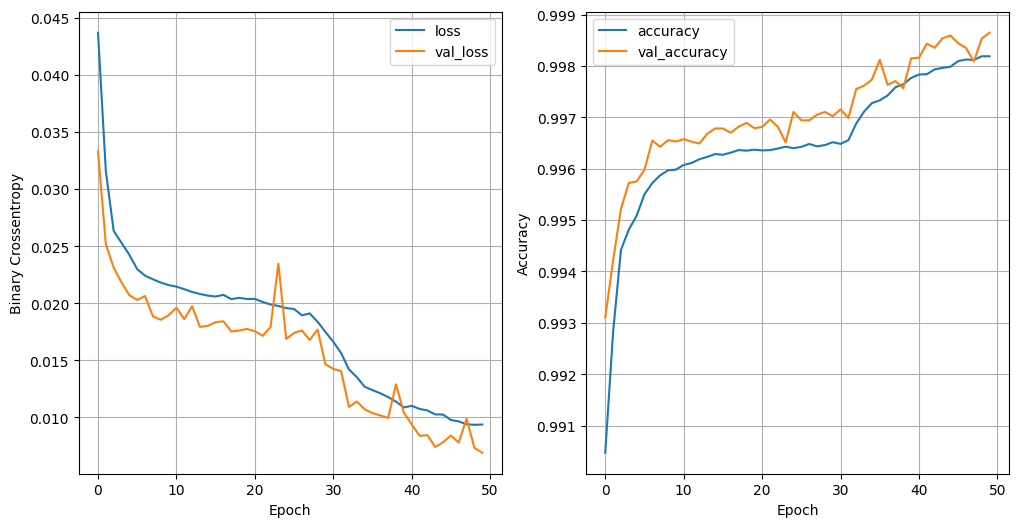

6305/6305 [==============================] - 6s 875us/step - loss: 0.0069 - accuracy: 0.9986
32 nodes, dropout_prob 0.2, lr 0.001, batch size 64


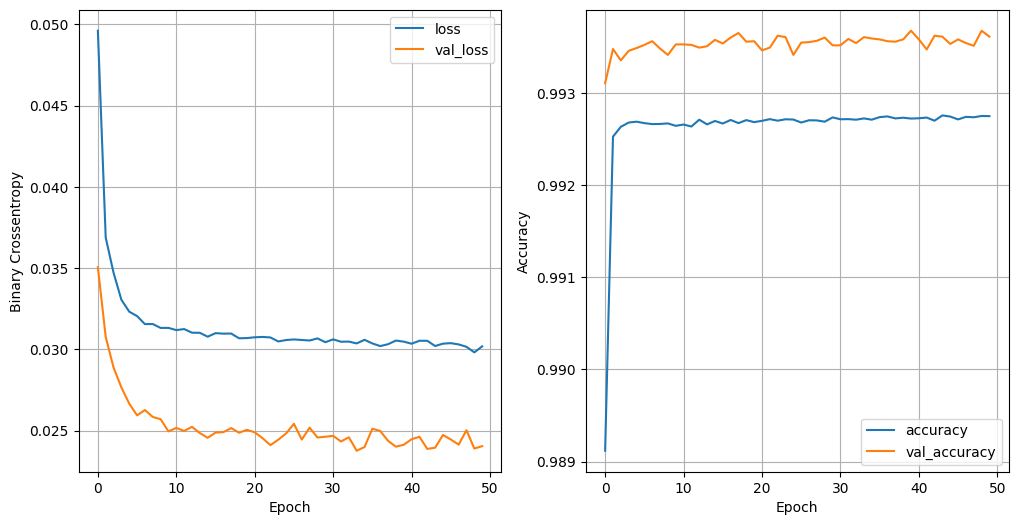

6305/6305 [==============================] - 5s 744us/step - loss: 0.0257 - accuracy: 0.9933
32 nodes, dropout_prob 0.5, lr 0.001, batch size 64


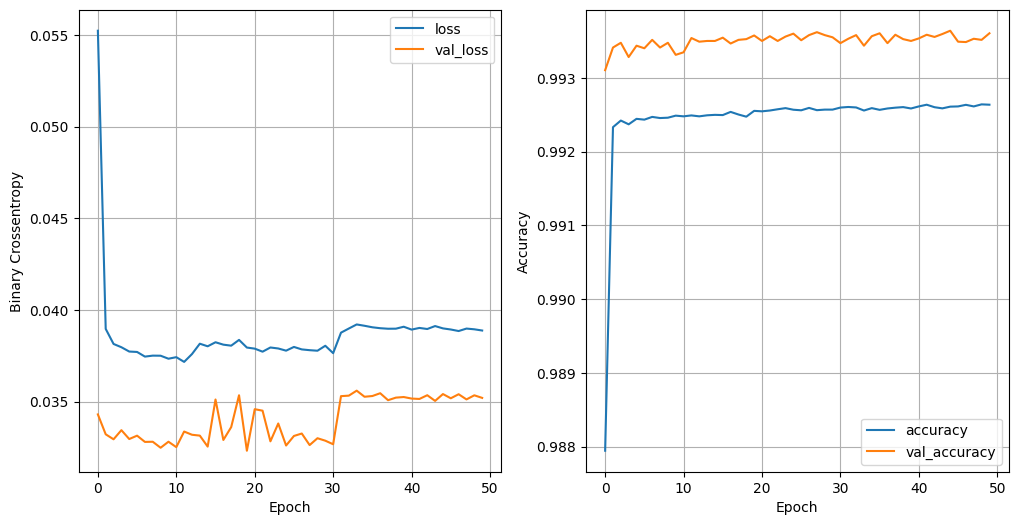

6305/6305 [==============================] - 5s 833us/step - loss: 0.0371 - accuracy: 0.9932


In [15]:
least_val_loss = float('inf')
least_loss_model = None
epochs = 50
for nodes in [32]:
    for dropout_prob in [0]:
        for lr in [0.001]:
            for batch_size in [64]:
                print(f"{nodes} nodes, dropout_prob {dropout_prob}, lr {lr}, batch size {batch_size}")
                model, history = nn_train(X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, epochs=epochs, nodes=nodes, dropout_prob=dropout_prob, lr=lr, batch_size=batch_size)
                plot_nn(history=history)
                val_loss = model.evaluate(X_test, y_test)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model


In [17]:
least_loss_model.save('models/dataset_merged_keras_model')

INFO:tensorflow:Assets written to: models/dataset_merged_keras_model/assets


INFO:tensorflow:Assets written to: models/dataset_merged_keras_model/assets
